# Yelp collaborative filtering -- ALS

In [1]:
## preps
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
%matplotlib inline

from sklearn.metrics import mean_squared_error

In [2]:
!pwd

/content


## 1. Loading Data

In [3]:
# Load three pre-processed datasets: reviews data, business data for selected candidate cities

## The restaurants in the five candidate cities
df_res_bus = pd.read_csv("/content/drive/My Drive/cleaned dataset/business_data_subset.csv", index_col= None)
### reviews in the top ten candidate cities
reviews = pd.read_csv("/content/drive/My Drive/cleaned dataset/reviews_data_subset.csv")

In [ ]:
df_res_bus.head()

,business_id,business_name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,4508 E Independence Blvd,Charlotte,NC,28205,35.194894,-80.767442,3.0,5,0,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...","Food, Restaurants, Grocery, Middle Eastern",NaN
1,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,1,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","Food, Pretzels, Bakeries, Fast Food, Restaurants","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
2,fnZrZlqW1Z8iWgTVDfv_MA,Carl's Jr,9595 W Tropicana Ave,Las Vegas,NV,89147,36.099738,-115.301568,2.5,15,0,"{'Alcohol': ""u'none'"", 'WiFi': ""u'no'"", 'GoodF...","Mexican, Restaurants, Fast Food",NaN
3,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,843 Kipling Avenue,Toronto,ON,M8Z 5G9,43.633291,-79.531768,3.0,13,0,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Restaurants, Burgers, Food",NaN
4,fhNf_sg-XzZ3e7HEVGuOZg,Meat Chix And Wieners,6530 S Decatur Blvd,Las Vegas,NV,89118,36.071196,-115.207463,3.0,10,0,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","Burgers, Restaurants, American (Traditional), ...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."


In [ ]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0.0,0.0,0.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
1,JA-xnyHytKiOIHl_ztnK9Q,P6apihD4ASf1vpPxHODxAQ,e_BiI4ej1CW1F0EyVLr-FQ,5.0,0.0,0.0,0.0,Most delicious authentic Italian I've had in t...,2015-02-16 06:48:47
2,bVTjZgRNq8ToxzvtiVrqMA,2hRe26HSCAWbFRn5WChK-Q,d4qwVw4PcN-_2mK2o1Ro1g,1.0,0.0,0.0,0.0,10pm on a super bowl Sunday and they're alread...,2015-02-02 06:28:00
3,UGErdm6bt48SXTVwJIti2Q,QodunSzok4nIYFNrTSGesQ,poSV39UqEg-gpESXafS9-g,3.0,0.0,0.0,0.0,My husband and I go there once a week since la...,2018-03-04 01:03:53
4,TeX0eOIeZb_wpo86rCedXQ,RR-2nouBn408e3djxC470g,d4qwVw4PcN-_2mK2o1Ro1g,5.0,0.0,0.0,0.0,Holy heck this place is amazing. I love their ...,2017-02-09 04:25:03


In [4]:
## merge the two 
df_merge = pd.merge(reviews, df_res_bus[['city','categories', 'business_id',"review_count"]], how = "outer", on ="business_id")
# df_toronto.to_csv("merged_Toronto_reviews.csv", index = None)
df_merge.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,categories,review_count
0,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0.0,0.0,0.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52,Las Vegas,"Restaurants, Mexican",56.0
1,Q9pkOKlRbHZy1pTUkTcBnQ,m-BZLIIh5PCAKnzH0qj_0Q,5JxlZaqCnk1MnbgRirs40Q,3.0,2.0,1.0,1.0,The three stars here don't represent a real re...,2012-06-26 07:51:00,Las Vegas,"Restaurants, Mexican",56.0
2,Y6hcNJ2bek3hSG4wm4UHKQ,PKEzKWv_FktMm2mGPjwd0Q,5JxlZaqCnk1MnbgRirs40Q,4.0,4.0,1.0,1.0,"I've been here several times, but I never revi...",2011-02-15 02:35:38,Las Vegas,"Restaurants, Mexican",56.0
3,E7Qtf8zR-e2wXFpVuaNDWQ,GdnJtqYWVSBAjya-WdN5RQ,5JxlZaqCnk1MnbgRirs40Q,2.0,2.0,0.0,0.0,I took my folks here last weekend for dinner o...,2012-05-30 18:54:30,Las Vegas,"Restaurants, Mexican",56.0
4,Q3kju7l36U0KWfuZRL_wlw,bX_VFU48rabrU_yHNL2XZg,5JxlZaqCnk1MnbgRirs40Q,4.0,0.0,0.0,0.0,"Above average in taste & presentation, which i...",2012-11-07 00:05:33,Las Vegas,"Restaurants, Mexican",56.0


### 1.1 Set city to Phoenix

In [5]:
city = "Phoenix"

In [6]:
df_city_bus_ids = df_res_bus[df_res_bus["city"] == city].business_id.unique()
reviews_city = reviews[reviews["business_id"].isin(df_city_bus_ids)]
reviews_city.shape

(510982, 9)

In [7]:
df_city_res = df_merge[df_merge["city"] == city]
df_city_res.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,categories,review_count
1290,UGErdm6bt48SXTVwJIti2Q,QodunSzok4nIYFNrTSGesQ,poSV39UqEg-gpESXafS9-g,3.0,0.0,0.0,0.0,My husband and I go there once a week since la...,2018-03-04 01:03:53,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384.0
1291,aBWKb49Xfkv1946YN7_SIg,sSPbLBHcEMXaJfoO8zs1bA,poSV39UqEg-gpESXafS9-g,5.0,0.0,0.0,0.0,"Amazing food, drinks, service!\n\nWe started w...",2016-01-17 05:33:14,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384.0
1292,jCHaWXgppmZjkOdpFltWGA,D5ywfFmwtJxLReqAYlDDmw,poSV39UqEg-gpESXafS9-g,5.0,3.0,0.0,2.0,I couldn't be more excited to have found this ...,2016-01-30 01:13:29,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384.0
1293,KvJ8yT-dODmCYe21J-Pp_A,gjoN4q-f61kwjmmU4mm1_g,poSV39UqEg-gpESXafS9-g,2.0,0.0,0.0,0.0,"The craft beers are very good, but that's abou...",2016-03-30 22:28:36,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384.0
1294,f88r8XKT_rPrKfyqfwRs3w,zJOGWBbq1mt3RLbKe9XgBg,poSV39UqEg-gpESXafS9-g,4.0,0.0,0.0,0.0,Great HH and awesome catfish dinner for only $...,2017-04-19 11:40:31,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384.0


### 1.2 filter low review users

In [8]:
def getCleanReviews(reviews, min_reviews = 5):
    review_counts = reviews.groupby("user_id")["review_id"].count().sort_values()
    return reviews.loc[reviews["user_id"].isin(review_counts[review_counts >= min_reviews].index.values)]

reviews_clean = getCleanReviews(reviews_city, min_reviews=5)
print(reviews_clean.describe())
print("//")
print("number of users:")
print(reviews_clean["user_id"].nunique())

               stars         useful          funny           cool
count  262292.000000  262292.000000  262292.000000  262292.000000
mean        3.831127       1.575210       0.709004       0.956789
std         1.267949       3.683419       2.274797       3.146895
min         1.000000       0.000000       0.000000       0.000000
25%         3.000000       0.000000       0.000000       0.000000
50%         4.000000       1.000000       0.000000       0.000000
75%         5.000000       2.000000       1.000000       1.000000
max         5.000000     178.000000     169.000000     160.000000
//
number of users:
20481


In [9]:
def get_clean_df(df, min_user_review = 5, min_res_review = 1, cols = ['user_id', 'business_id', 'stars']):
    '''Cleans the df and gets rid of the unwanted cols and also allows to filter the user and business based on the min number of reviews received'''
    df_new = df[cols]
    df_new.dropna(axis = 0, how = 'any', inplace = True)
    df_new["business_freq"] = df_new.groupby(cols[1])[cols[1]].transform('count')
    df_new =  df_new[df_new['business_freq']>=min_res_review]
    df_new['user_freq'] = df_new.groupby(cols[0])[cols[0]].transform('count')
    df_new = df_new[df_new['user_freq']>=min_user_review]
    return df_new
    
def get_sparse_matrix(df):
    '''Converts the df into a sparse ratings matrix'''
    unique_users = list(df['user_id'].unique())
    unique_bus = list(df['business_id'].unique())
    data = df['stars'].tolist()
    row = pd.Series(pd.Categorical(df["user_id"],categories=unique_users)).cat.codes
    
#     df['user_id'].astype('category', categories=unique_users).cat.codes
#     col = df['business_id'].astype('category', categories=unique_bus).cat.codes
    col = pd.Series(pd.Categorical(df["business_id"], categories=unique_bus)).cat.codes
    sparse_matrix = csr_matrix((data, (row, col)), shape=(len(unique_users), len(unique_bus)))
    return sparse_matrix    

In [10]:
df_clean= get_clean_df(df_city_res,min_user_review= 20, min_res_review=20)
df_clean.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(111007, 5)

In [11]:
df_clean.head()

,user_id,business_id,stars,business_freq,user_freq
1292,D5ywfFmwtJxLReqAYlDDmw,poSV39UqEg-gpESXafS9-g,5.0,405,22
1297,CyL4Nh9VHti5oIfcWevRIg,poSV39UqEg-gpESXafS9-g,5.0,405,38
1302,c40DTzCb-fHY6vI03PNRLw,poSV39UqEg-gpESXafS9-g,4.0,405,65
1312,Q6Dcxo3_lNCzkqK7J3FL7A,poSV39UqEg-gpESXafS9-g,3.0,405,139
1314,Tr7YMpWd1XZdXdm35CatqA,poSV39UqEg-gpESXafS9-g,2.0,405,30


In [12]:
## Sparcity
df_spar_matrix = get_sparse_matrix(df_clean)
print("City:")
print(city)
print("*"*100)
print("number of unique users:")
print(df_spar_matrix.shape[0])
print("number of unique restaurants:")
print(df_spar_matrix.shape[1])
print("total reviews:")
print(df_clean.shape[0])
print("*"*100)

City:
Phoenix
****************************************************************************************************
number of unique users:
2675
number of unique restaurants:
2802
total reviews:
111007
****************************************************************************************************


In [13]:
## sparcity
sparsity_clt = 1 - df_spar_matrix.nnz/(df_spar_matrix.shape[0]*df_spar_matrix.shape[1])
sparsity_clt


0.9863313921297872

### 1.3 Train-Valid-Test split

In [14]:
def train_val_test_split(sparse_matrix, num_review_val = 2, num_review_test = 2):
    '''Split the rating matrix into train ,val, and test marix that are disjoint matrices'''
    nzrows, nzcols =  sparse_matrix.nonzero()
    sparse_matrix_test = csr_matrix(sparse_matrix.shape)
    sparse_matrix_val = csr_matrix(sparse_matrix.shape)
    sparse_matrix_train = sparse_matrix.copy()
    n_users = sparse_matrix.shape[0]
    for u in range(n_users):
        idx = nzcols[np.where(nzrows == u)]
        np.random.shuffle(idx)
        test_idx = idx[-num_review_test:]
        val_idx = idx[-(num_review_val+num_review_test):-num_review_test]
        train_idx = idx[:-(num_review_val+num_review_test)]
        sparse_matrix_test[u,test_idx] = sparse_matrix[u,test_idx]
        sparse_matrix_val[u,val_idx] = sparse_matrix[u,val_idx]
        sparse_matrix_train[u,test_idx] = 0
        sparse_matrix_train[u,val_idx] = 0
    data = np.array(sparse_matrix_train[sparse_matrix_train.nonzero()])[0]
    row = sparse_matrix_train.nonzero()[0]
    col = sparse_matrix_train.nonzero()[1]
    size = sparse_matrix_train.shape
    sparse_matrix_train = csr_matrix((data,(row,col)),shape = size)
    mult = sparse_matrix_train.multiply(sparse_matrix_val)
    mmult = mult.multiply(sparse_matrix_test)
    assert(mmult.nnz == 0)
    return sparse_matrix_train, sparse_matrix_val, sparse_matrix_test

In [15]:
df_train, df_val, df_test = train_val_test_split(df_spar_matrix)


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [16]:
sparse.save_npz("df_clt_train.csv",df_train )
sparse.save_npz("df_clt_val.csv",df_val )
sparse.save_npz("df_clt_test.csv",df_test ) #/content/...

In [17]:
print(df_train.nnz, df_val.nnz, df_test.nnz)

91751 5350 5350


In [ ]:
df_train

<2675x2802 sparse matrix of type '<class 'numpy.float64'>'
	with 91751 stored elements in Compressed Sparse Row format>

## 2 Build model

### 2.1 ALS

$$\text{User-Restaurant Rating Matrix}(N*M) = \text{User Matrix}(N*K) * \text{Item Matrix}(K*M)$$
$$\text{minimize: } L = \sum_{i=1}^N\sum_{j=1}^M[(R_{ij}-U_i^TV_j)^2+\lambda(||U_i||^2+||V_j||^2)]$$
$$\text{fix}V_j=V_j^{(0)} $$
$$\Longrightarrow\frac{\partial{L}}{\partial{U_i}} = 2\sum_{j=1}^M[(V_j^{(0)T}V_j^{(0)}+\lambda)U_i-R_{ij}V_j^{(0)}]\text{  }$$
$$\Longrightarrow \sum_{j=1}^M[(V_j^{(0)T}V_j^{(0)}+\lambda)U_i]=\sum_{j=1}^MR_{ij}V_j^{(0)} \Longrightarrow (VV^T+\lambda E)U_i = VR_i^T$$

$$\text{fix} U_i=U_i^{(0)}$$
$$\Longrightarrow\frac{\partial{L}}{\partial{V_j}} = 2\sum_{i=1}^N[(U_i^{(0)T}U_i^{(0)}+\lambda)V_j-R_{ij}U_i^{(0)}]\text{  }$$
$$\Longrightarrow \sum_{i=1}^N[(U_i^{(0)T}U_i^{(0)}+\lambda)V_j]=\sum_{i=1}^NR_{ij}U_i^{(0)} \Longrightarrow (UU^T+\lambda E)V_j = UR_j^T$$


In [18]:
def als(ratings_matrix, k=40, user_reg=0, res_reg=0, iters=10):
    '''Performs ALS for a given ratings_matrix and returns predictions using the latent vector representation User (U x K) and Restaurant (R x K)'''
    ratings_matrix = ratings_matrix.T
    user_vec = np.random.rand(ratings_matrix.shape[1],k).T
    res_vec = np.random.rand(ratings_matrix.shape[0],k).T
    for i in range(iters):
        for u in range(ratings_matrix.shape[1]):
            user_vec[:,u] = np.linalg.solve(np.dot(res_vec,res_vec.T) + user_reg * np.eye(res_vec.shape[0]), np.dot(res_vec,ratings_matrix[:,u]))
        for r in range(ratings_matrix.shape[0]):
            res_vec[:,r] = np.linalg.solve(np.dot(user_vec,user_vec.T) + res_reg * np.eye(user_vec.shape[0]), np.dot(user_vec,ratings_matrix[r,:].T))
        prediction = np.dot(res_vec.T, user_vec)
#         error = np.mean((ratings_matrix - prediction)**2)
    return np.dot(res_vec.T, user_vec).T


In [19]:
def get_mse(pred, actual):
    # Ignore zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

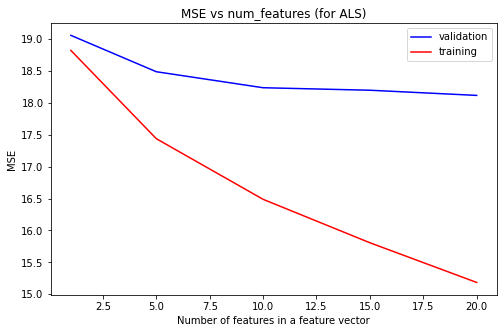

In [20]:
num_features = np.linspace(1,20,5,dtype=int)
test_error_als = []
train_error_als = []
for i in num_features:
    preds_als = als(np.array(df_train.todense()), k=i, iters = 5)
    test_err = get_mse(preds_als, np.array(df_val.todense()))
    train_err = get_mse(preds_als, np.array(df_train.todense()))
    test_error_als.append(test_err)
    train_error_als.append(train_err)

fig = plt.figure(figsize=(8,5))
plt.plot(num_features,test_error_als,'b-',label = 'validation')
plt.plot(num_features,train_error_als,'r-', label = 'training')
plt.title('MSE vs num_features (for ALS)')
plt.xlabel('Number of features in a feature vector')
plt.ylabel('MSE')
plt.legend()

tuning $\lambda$

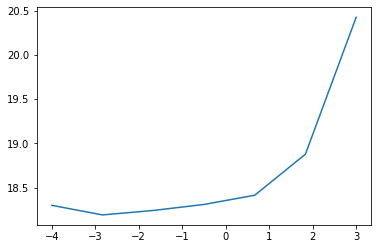

In [32]:
plt.plot(np.log10(user_reg),list(val_error_als.values()))

Text(0, 0.5, 'MSE')

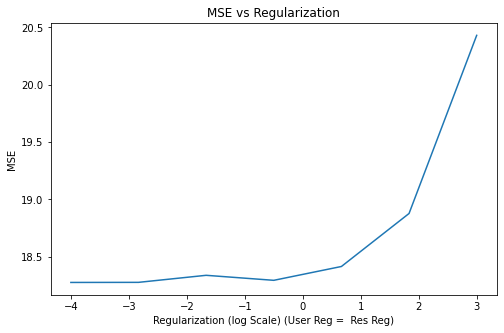

In [33]:
user_reg= np.logspace(-4,3,7)
val_error_als = {}
# train_error_als = {}
fig = plt.figure(figsize=(8,5))
for i in user_reg:
    val_error_als[i] = []
    preds_als = als(np.array(df_train.todense()),k=10, iters = 5, user_reg=i, res_reg=i)
    val_err = get_mse(preds_als, np.array(df_val.todense()))
#         train_err = get_mse(preds_als, np.array(train.todense()))
    val_error_als[i].append(val_err)
#         train_error_als[i].append(train_err)
plt.plot(np.log10(user_reg),list(val_error_als.values()))
#     plt.plot(np.log(res_reg),train_error_als[i], label = 'User_reg = '+ str(i))


plt.title('MSE vs Regularization')
plt.xlabel('Regularization (log Scale) (User Reg =  Res Reg)')
plt.ylabel('MSE')